# Описание проекта

<b> Сеть фитнес-центров «Культурист-датасаентист» разрабатывает стратегию взаимодействия с клиентами на основе аналитических данных.

Проблема — отток клиентов. 

Задача — провести анализ и подготовить план действий по удержанию клиентов.

Набор данных включает следующие поля:
 
Данные клиента за предыдущий до проверки факта оттока месяц:

'gender' — пол;

'Near_Location' — проживание или работа в районе, где находится фитнес-центр;

'Partner' — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента);

Promo_friends — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента);

'Phone' — наличие контактного телефона;

'Age' — возраст;

'Lifetime' — время с момента первого обращения в фитнес-центр (в месяцах).

Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента:

'Contract_period' — длительность текущего действующего абонемента (месяц, 6 месяцев, год);

'Month_to_end_contract' — срок до окончания текущего действующего абонемента (в месяцах);

'Group_visits' — факт посещения групповых занятий;

'Avg_class_frequency_total' — средняя частота посещений в неделю за все время с начала действия абонемента;

'Avg_class_frequency_current_month' — средняя частота посещений в неделю за предыдущий месяц;

'Avg_additional_charges_total' — суммарная выручка от других услуг фитнес-центра: кафе, спорттовары, косметический и массажный салон.

'Churn' — факт оттока в текущем месяце.

## Загрузка данных.

In [1]:
# загрузим библиотеки
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
# загрузим файл
df=pd.read_csv('/datasets/gym_churn.csv', sep=',')
display(df.head())

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


In [3]:
# посмотрим информацию
display(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

None

Пропусков нет.

In [4]:
# приведем названия столбцов в нижний регистр
df.columns=df.columns.str.lower()
#display(df.head())

In [5]:
df.duplicated().sum()

0

Дубликатов нет.

<b> Вывод:</b>  Таблица имеет 14 колонок и 4000 строк. Данные не имеют пропусков и дубликатов.

## Исследовательский анализ данных.

### Средние значения и стандартные отклонения .

In [6]:
# описание данных
df.describe()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,1.000000


In [7]:
display(df['gender'].value_counts())
display(df['near_location'].value_counts())
display(df['partner'].value_counts())
display(df['promo_friends'].value_counts())
display(df['phone'].value_counts())
display(df['contract_period'].value_counts())
display(df['group_visits'].value_counts())
display(df['age'].value_counts())
display(df['churn'].value_counts())

1    2041
0    1959
Name: gender, dtype: int64

1    3381
0     619
Name: near_location, dtype: int64

0    2053
1    1947
Name: partner, dtype: int64

0    2766
1    1234
Name: promo_friends, dtype: int64

1    3614
0     386
Name: phone, dtype: int64

1     2207
12     960
6      833
Name: contract_period, dtype: int64

0    2351
1    1649
Name: group_visits, dtype: int64

29    468
30    457
28    447
31    434
27    378
32    364
26    300
33    253
25    231
34    174
24    148
35     98
23     82
36     48
22     33
37     29
21     24
20     14
38     10
39      3
18      2
19      2
41      1
Name: age, dtype: int64

0    2939
1    1061
Name: churn, dtype: int64

<b> Вывод:</b>  Аномальных значений в таблице визуально нет.

- пол клиентов 'gender' - примерно поровну.


- проживание или работа в районе, где находится фитнес-центр 'near_location' - намного больше живущих ближе, что логично.


- сотрудник компании-партнёра клуба 'partner' - примерно поровну.


- факт первоначальной записи в рамках акции «приведи друга» 'promo_friends' - треть клиентов приходят по рекомендации.


- наличие контактного телефона 'phone' - большинство клиентов оставляют свой контактный номер.


- длительность текущего действующего абонемента 'contract_period' - большинство предпочитает покупать абонемент на месяц.


- факт посещения групповых занятий 'group_visits' - большинство не посещяет, но посещяющих всего примерно на 20% меньше.


- возраст 'age' - минимум 18 максимум 41, большинство 25-35.


- факт оттока в текущем месяце 'churn' - отток - 1061 нет оттока -  2939.


- время с момента первого обращения в фитнес-центр (в месяцах) 'lifetime' - 0-31 месяц, среднее 4.6 месяцев.


- срок до окончания текущего действующего абонемента (в месяцах) 'month_to_end_contract' - 1-12 месяцев, среднее 3.7 месяца.


- средняя частота посещений в неделю за все время с начала действия абонемента 'avg_class_frequency_total' - 0-6 посещений, среднее 1.88.


- средняя частота посещений в неделю за предыдущий месяц 'avg_class_frequency_current_month' - 0-6,1 посещения, среднее 1,7.


- суммарная выручка от других услуг фитнес-центра 'avg_additional_charges_total' - 0-553, среднее 147.

### Средние значения признаков в двух группах.

In [8]:
display(df.groupby(['churn']).mean())

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month
churn,,,,,,,,,,,,,
0,0.510037,0.873086,0.534195,0.353522,0.903709,5.747193,0.464103,29.976523,158.445715,5.283089,4.711807,2.024876,2.027882
1,0.510839,0.768143,0.355325,0.183789,0.902922,1.728558,0.268615,26.989632,115.082899,1.662582,0.990575,1.474995,1.044546


<b> Вывод: </b> 
- Пол не влияет на отток клиентов.


- Клиенты, которые проживают/работают в районе клуба, чаще остаются к клубе.


- Клиенты, сотрудники компаний- партнеров чаще остаются в клубе.


- Клиенты, пришедшие сами, а не через друзей остаются в клубе чаще.


- Клиенты, не ушедшие, чаще имеют более длинный абонимент 5.7 меясца, против 1.7 месяца у тех кто ушёл, что логично.


- Групповое посещение чаще у тех кто не ушёл.


- Возраст примерно одинаковый.


- Дополнительные траты выше у тех кто остается.


- Месяцев до окончания договора 5.28 в среднем у тех кто остается, 1.66 у тех кто уходит. 


- Продолжительность использования 4.7 у тех кто остаеться, 1 месяц у тех то уходит, чаще всего отток после первого месяца. 


- Те кто остаются чаще посещают занятия: за всё время - 2 против 1.47, месячный пока затель 2 против 1.

### Строим столбчатые гистограммы и распределения признаков для тех, кто ушёл (отток) и тех, кто остался (не попали в отток).

Разделим выборки на клиентов.

In [9]:
churn_1 = df.query('churn == 1')
churn_0 = df.query('churn == 0')

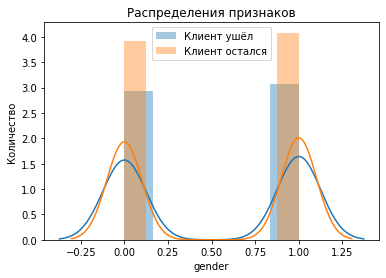

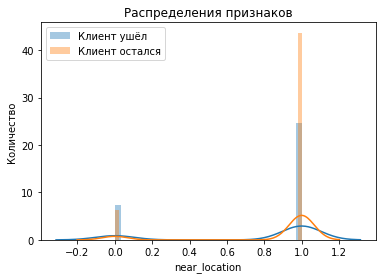

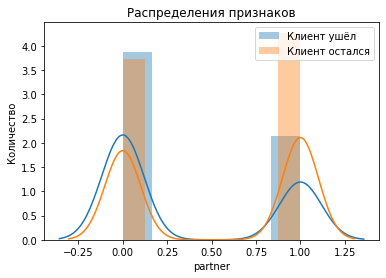

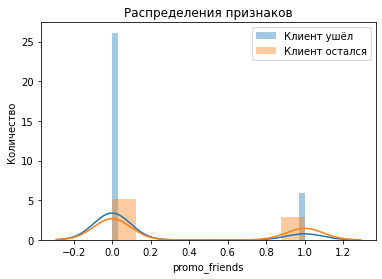

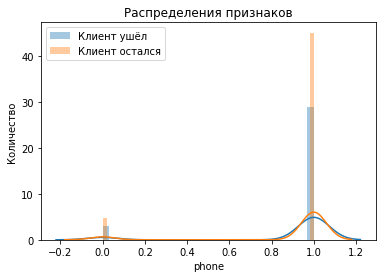

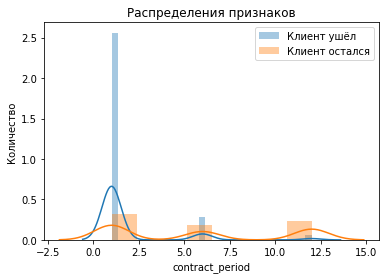

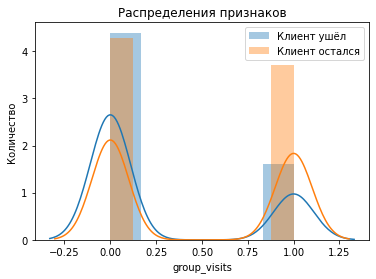

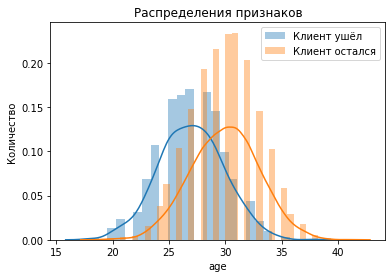

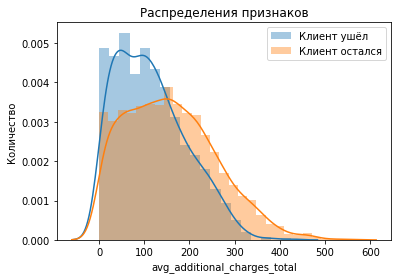

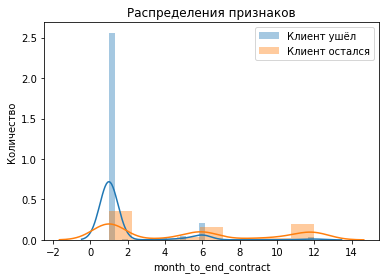

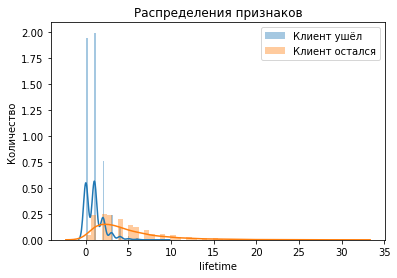

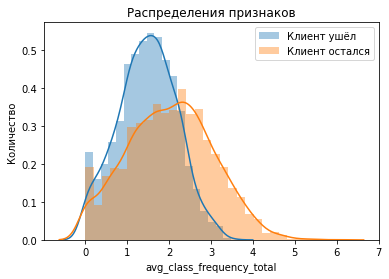

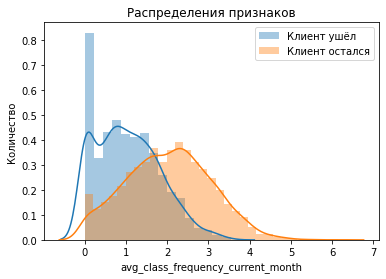

In [10]:
# Построим столбчатые гистограммы и распределения
fig, ax = plt.subplots()
for column in df.drop('churn', axis = 1).columns:
    plt.title('Распределения признаков')
    plt.xlabel(column)
    plt.ylabel('Количество')
    sns.distplot(churn_1[column], label='Клиент ушёл')
    sns.distplot(churn_0[column], label='Клиент остался')
    plt.legend()
    plt.show()

<b> Вывод: </b> 
- Мужчины и женщину уходят/остаются одинаково.


- Те кто живут далеко уходят/остаются одинаково, те кто живут в районе фитнеса чаще остаются.


- Сотрудники компаний-партнеров остаются в два раза чаще, остальные уходят/остаются одинаково.


- Клиенты пришедшие по приглашению друзей уходят в два раза чаще, чем остаються, клиенты пришедшие без рекомендации уходят в пять раз чаще.


- Клиенты которые оставляют / не оставляют телефон ведут себя примерно одинаково, те кто оставляют номер чаще остатся.


- Если клиент купил абонемент на один месяц то скорее всего произойдёт его отток, разнича большая, если абонимент на полгода ушедних не сильно больше чем оставшихся, клиенты купившие абонимент на год остаются чаще.


- Клиенты не посещающие групповые занятия уходят/остаются одинаково, клиенты посещающие групповые занятия остаються в два раза чаще.


- Распределение по возрасту - чаще всего имеют отток клиенты 20-27 лет, клиенты старше 30-40 имеют меньшую склонность к оттоку.


- Распределение по доп тратам, те кто уходят меньше дополнительно тратят.


- Клиенты у которых остался месяц до окончания абонимента уходят чаще всего, клиенты у которых до конца абонимента больший период уходят меньше.


- Распределение по времени с момента первого обращения - в первых месяц происходит наибольший отток.


- Распредиление частоты посещения за весь период - те кто уходят посещают реже чем те кто остаются.


- Распредиление частоты посещения за последний месяц - те кто уходят посещают реже чем те кто остаются, даже вообще не посещают.

###  Постройте матрицу корреляций.

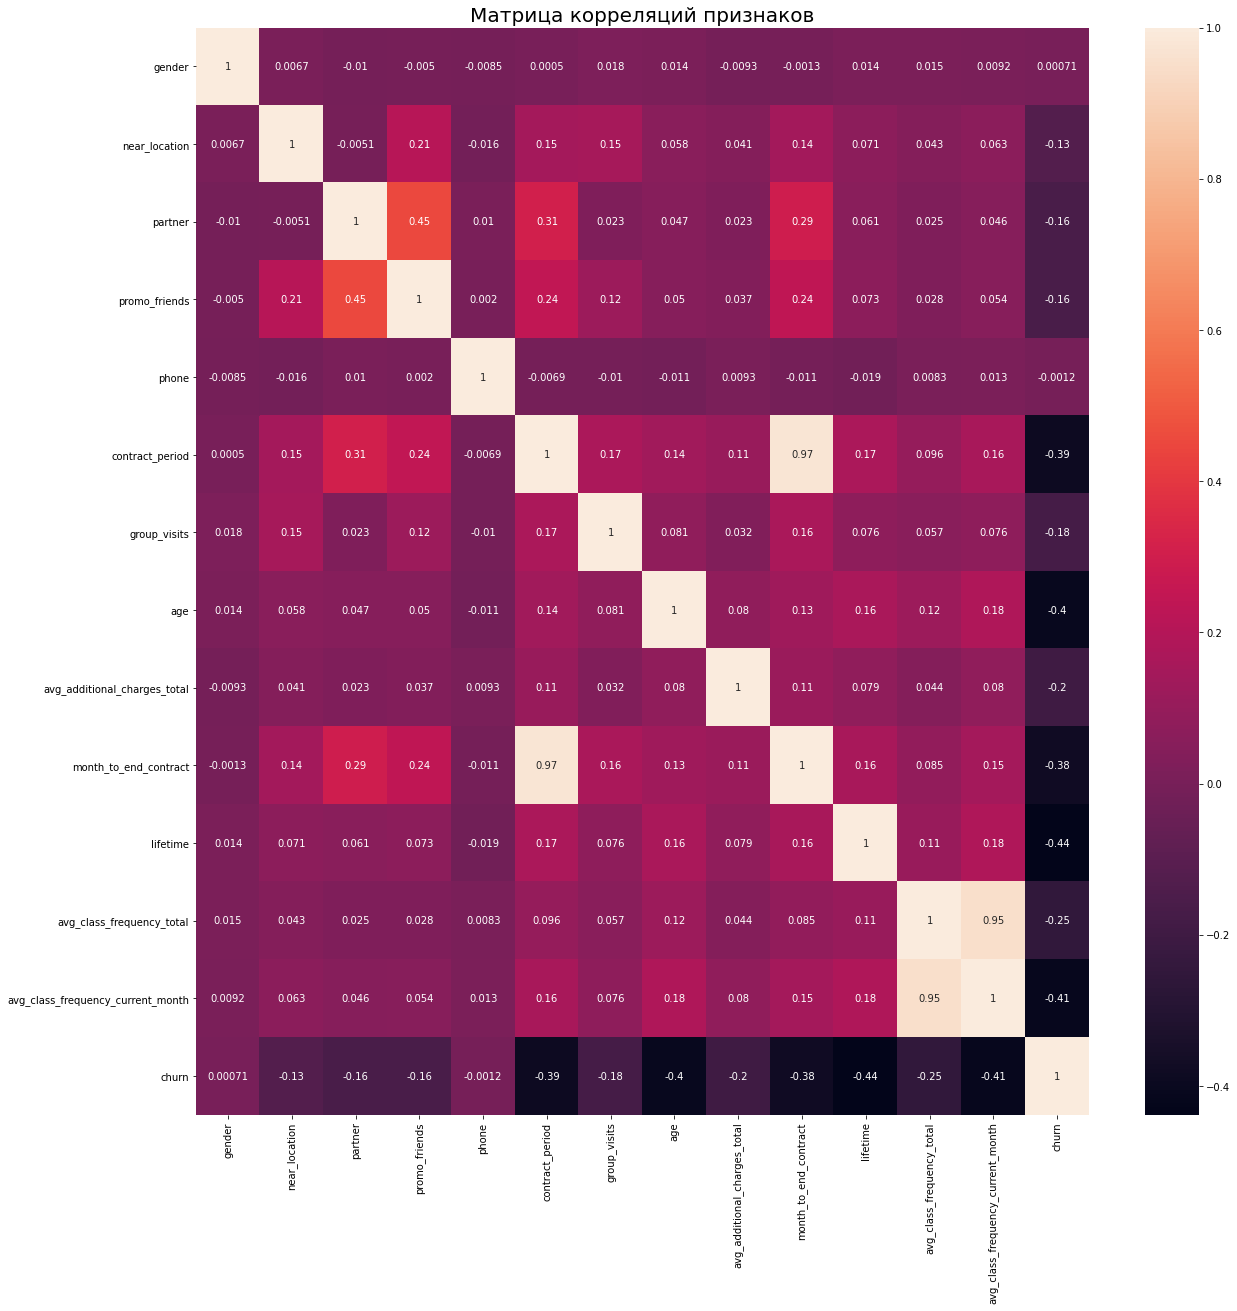

In [11]:
matr = df.corr()
plt.figure(figsize=(20,20))
sns.heatmap(matr, annot = True, square=False)
plt.title('Матрица корреляций признаков', fontsize = 20)
plt.show()

<b> Вывод: </b> 

<b> Показатели которые сильно влияют на отток: </b> 

- длительность текущего действующего абонемента 'contract_period'

- возраст 'age'

- срок до окончания текущего действующего абонемента 'month_to_end_contract'

- время с момента первого обращения в фитнес-центр 'lifetime'

- средняя частота посещений в неделю за предыдущий месяц 'avg_class_frequency_current_month'

<b> Другие заметные корреляции показателей: </b>

- сотрудник компании-партнёра клуба 'partner'  и факт первоначальной записи в рамках акции «приведи друга» 'promo_friends'

- длительность текущего действующего абонемента 'contract_period'  и сотрудник компании-партнёра клуба 'partner' 

- срок до окончания текущего действующего абонемента 'month_to_end_contract и сотрудник компании-партнёра клуба 'partner' 

- срок до окончания текущего действующего абонемента 'month_to_end_contract и длительность текущего действующего абонемента 'contract_period' - корреляция  0.97

- средняя частота посещений в неделю за предыдущий месяц 'avg_class_frequency_current_month' и средняя частота посещений в неделю за все время с начала действия абонемента 'avg_class_frequency_total' корреляция 0.95

## Строим модель прогнозирования оттока клиентов.

Построем модель бинарной классификации клиентов, где целевой признак — факт оттока клиента в следующем месяце.

In [12]:
# разделим данные
X = df.drop(['churn'], axis = 1)
y = df['churn']

# разобъем данные на обучающую и валидационную выборку 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# обучаем модель

# зададим алгоритм для модели логистической регрессией и обучим модель
model_lr = LogisticRegression(random_state=0)
model_lr.fit(X_train, y_train)

# зададим алгоритм для модели случайный лес и обучим модель
model_rfc = RandomForestClassifier(random_state=0)
model_rfc.fit(X_train, y_train)

RandomForestClassifier(random_state=0)

Оценим метрики accuracy, precision и recall для обеих моделей на валидационной выборке. 

In [13]:
# модель логистической регрессии
y_pred=model_lr.predict(X_test)
accuracy=accuracy_score(y_test, y_pred)
precision=precision_score(y_test,y_pred)
recall=recall_score(y_test, y_pred)

display('Accuracy: {:.2f}'.format(accuracy))
display('Precision: {:.2f}'.format(precision))
display('Recall: {:.2f}'.format(recall))

'Accuracy: 0.91'

'Precision: 0.82'

'Recall: 0.80'

In [14]:
# модель случайного леса
y_pred2=model_rfc.predict(X_test)
accuracy2=accuracy_score(y_test, y_pred2)
precision2=precision_score(y_test,y_pred2)
recall2=recall_score(y_test, y_pred2)

display('Accuracy: {:.2f}'.format(accuracy2))
display('Precision: {:.2f}'.format(precision2))
display('Recall: {:.2f}'.format(recall2))

'Accuracy: 0.92'

'Precision: 0.84'

'Recall: 0.82'

<b> Вывод:</b>  Алгоритм случайный лес в данном случает оказался точнее.

## Сделаем кластеризацию клиентов

### Cтандартизируем данные без столбца 'churn'.

In [15]:
# стандартизируем данные
scaler = StandardScaler()
X_st = scaler.fit_transform(X)

### Построение матрицы расстояний и дендрограммы


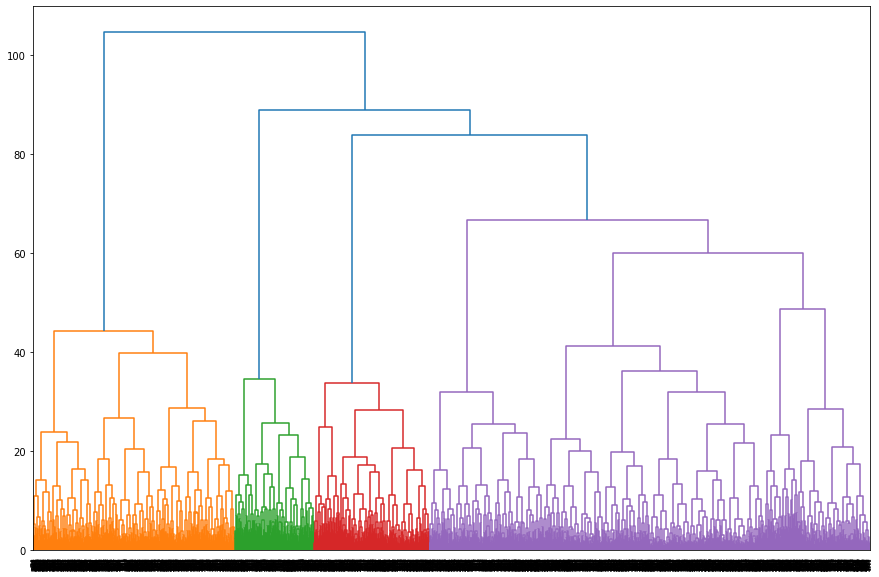

In [16]:
# строим матрицу
linked=linkage(X_st, method='ward')
# строим дендрограмму
plt.figure(figsize=(15,10))
dendrogram(linked, orientation='top')
plt.show()

<b> Вывод: </b> По дендрограмме можно выделить как минимум 4 кластера.

### Обучаем модель кластеризации на основании алгоритма K-Means и спрогнозируйте кластеры клиентов.

Договоримся за число кластеров принять n=5.

In [17]:
# обучаем модель кластирезации
km=KMeans(n_clusters=5, random_state=0)
labels=km.fit_predict(X_st)

### Cредние значения признаков для кластеров.

In [18]:
# применим группировку по кластерам и выведем среднее
df['cluster']=labels
df.groupby(['cluster']).mean()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
cluster,,,,,,,,,,,,,,
0,0.502970,0.959406,0.783168,0.574257,1.000000,10.889109,0.542574,29.982178,160.761016,9.954455,4.736634,1.982055,1.974789,0.027723
1,0.522078,0.862338,0.470130,0.306494,0.000000,4.787013,0.425974,29.301299,143.957664,4.475325,3.924675,1.847220,1.716369,0.267532
2,0.495050,0.000000,0.463366,0.079208,1.000000,2.352475,0.215842,28.477228,135.457501,2.198020,2.809901,1.660461,1.477324,0.443564
3,0.485737,1.000000,0.350238,0.240095,1.000000,1.948494,0.341521,28.167987,131.622204,1.856577,2.440571,1.247634,1.012983,0.514263
4,0.559666,0.976134,0.356802,0.230310,0.998807,2.669451,0.473747,30.125298,161.657905,2.459427,4.898568,2.852002,2.850161,0.068019


### Постройте распределения признаков для кластеров.

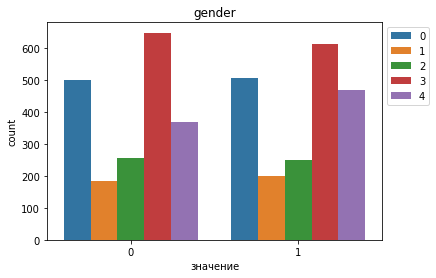

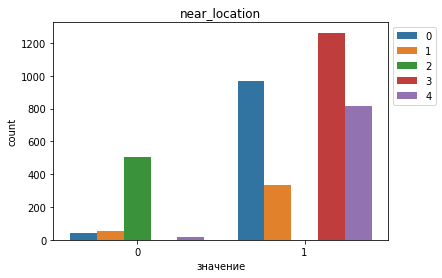

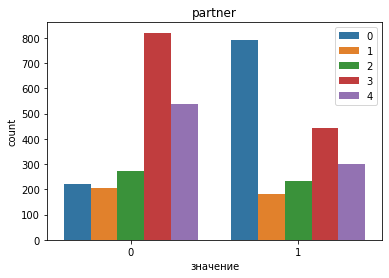

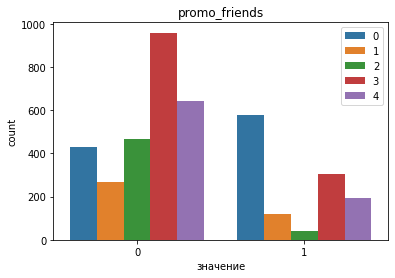

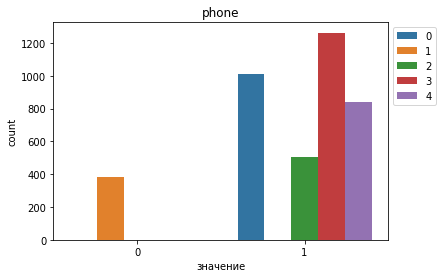

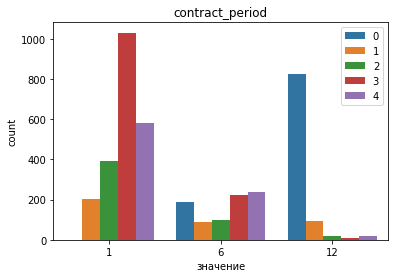

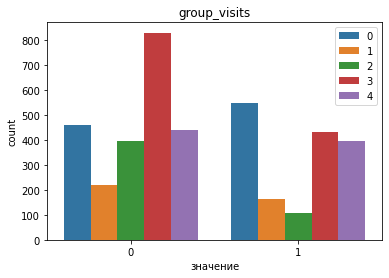

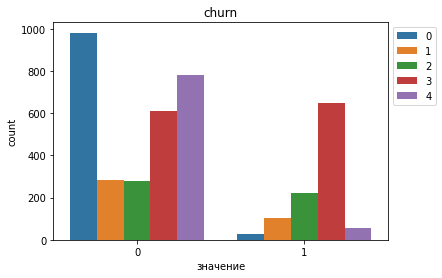

In [19]:
# построим распределение для дискретных величин
values = ['gender', 'near_location', 'partner', 'promo_friends', 'phone', 'contract_period', 'group_visits', 'churn']
fig, ax = plt.subplots()
for column in values:
    plt.title(column)
    sns.countplot(data=df, x=column, hue='cluster')
    plt.xlabel('значение')
    plt.legend(bbox_to_anchor=(1, 1))
    plt.show()

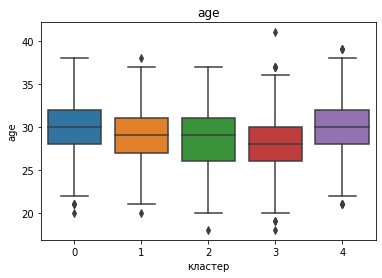

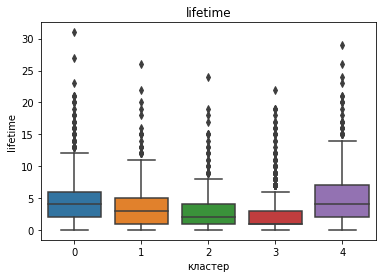

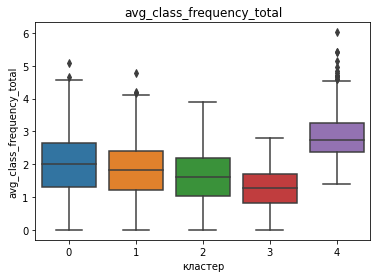

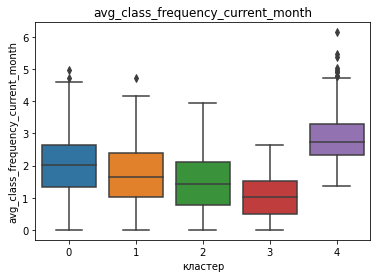

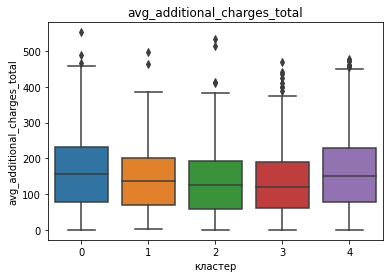

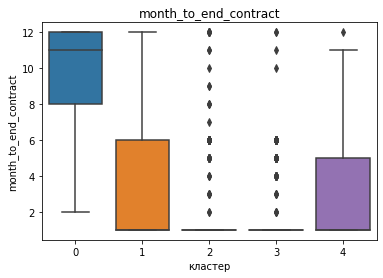

In [20]:
# построим распределение для непрерывных величин
values2 = ['age', 'lifetime','avg_class_frequency_total', 'avg_class_frequency_current_month', 'avg_additional_charges_total','month_to_end_contract']
fig, ax = plt.subplots()
for column in values2:
    sns.boxplot(x='cluster', y=column, data=df)
    plt.title(column)
    plt.xlabel('кластер')
    plt.ylabel(column)
    plt.show()

<b>Вывод:</b>

- пол клиентов 'gender' - в каждом кластере примерно поровну.


- проживание или работа в районе, где находится фитнес-центр 'near_location' - Кластер 2 все живут вне района, Кластер 3 все живут в районе, остальные кластеры в большинстве живут рядом.


- сотрудник компании-партнёра клуба 'partner' - Кластер 0 - большинство партнеры, Кластер 1,2 прмерно меньше половины, Кластер 3,4 треть


- факт первоначальной записи в рамках акции «приведи друга» 'promo_friends' - большинство в Кластре 0, меньше всего в Кластер 2


- наличие контактного телефона 'phone' - Кластер 1 нет, Остальные есть.


- длительность текущего действующего абонемента 'contract_period' -  Кластер 0 - 10, Кластре 1 -4, остальные около 2.


- факт посещения групповых занятий 'group_visits' - Самое большое Кластер 0 - 0,54, Кластер 2 - 0,21


- возраст 'age' - везде 28-30


- факт оттока в текущем месяце 'churn' - Кластер 0 - 0,02, самый большой отток Кластер 3 - 0,51.


- время с момента первого обращения в фитнес-центр (в месяцах) 'lifetime' - Кластер 4 - 4.9 месяцев и Кластер 0 -4.7 месяца самые высокие по значению

- срок до окончания текущего действующего абонемента (в месяцах) 'month_to_end_contract' - Кластер 0 10 месяцев, Кластер 1 - 6. класте 4 -5.


- средняя частота посещений в неделю за все время с начала действия абонемента 'avg_class_frequency_total' - Кластер 4 -2.8, остальные меньше.


- средняя частота посещений в неделю за предыдущий месяц 'avg_class_frequency_current_month' - Кластер 4 - 2.8


- суммарная выручка от других услуг фитнес-центра 'avg_additional_charges_total' - Кластер 0 и Кластре 4 - 161.



### Для каждого полученного кластера посчитаем долю оттока.

In [21]:
# посчитаем долю оттока
df.groupby(['cluster'])['churn'].mean()   

cluster
0    0.027723
1    0.267532
2    0.443564
3    0.514263
4    0.068019
Name: churn, dtype: float64

<b> Вывод:</b> 
Кластер в котором меньше всего оттока клиентов это кластер 0, самый большой отток кластер 3.

## Выводы и базовые рекомендации по работе с клиентами.

<b>Вывод:</b> 
Проведено исследование базы фитнес клуба, был проведен анализ по параметру отток клиентов.

- Отток клиентов вообщем составляет около 25%.
- Пол клиента не влияет на отток.
- Больше клиентов живет/работает вблизи и они более лояльны.
- Клиенты партнёров и пришедлие от друзей меньше оттекают.
- Клиенты в возрасте 18-40 лет, клинеты полсе 30 лет более лояльны.
- Менее подвержены оттоку клиенты купившие абонимент надолго, также они чаще занимаются, посещают групповые занятия, больше оставляют денег на доп услуги.

Кластеры: 

Кластер 0 - отток 2,77% 
Живут близко, пришли по программе партнеров и по рекомендации, абонимент куплен надолго, часто ходят на занятия, им дольше 30


Кластер 1 - отток 27%  
Никто не оставляет номер телефона, не ходят в группы.

Кластер 2 - отток 44% 
Все живут далеко, не пришли по рекомендации, не ходят в группы.

Кластер 3 - отток 51% :
Недавно занимаются, не по рекомендации, не ходят в группы.

Кластер 4 - отток 6.8% :
Живут близко, часто посещают, больше всех тратят на доп услуги.



<b>Рекомендации:</b>

1) Привлекать компании партнеры.

2) Привлекать постоянных поситителей приводить друзей.

3) Развивать групповые занятия.

4) Ориентироваться на клиентов после 30.

5) Привлекать клиентов заключать долгосрочные договоры.

6) Привлекать клиентов чаще посещять занятия.